# Forecasting Government Effectiveness: A Predictive Analysis of Socio-Economic Drivers and 2024 Risk Assessment for African Countries

**Prepared for:** Development Policy Professionals, International Organizations, and Government Stakeholders  
**Analysis Date:** February 2026  
**Data Sources:** World Development Indicators (WDI), Worldwide Governance Indicators (WGI)  
**Focus Dimension:** Government Effectiveness (SDG 16 - Institutions)  
**Geographic Scope:** 20 African Nations (17 Sub-Saharan Africa, 3 North Africa)  
**Key Outputs:** 2024 Governance Forecasts, Risk Assessments, Policy Recommendations

---

## Executive Summary
This analysis examines the relationship between socio-economic indicators (2019) and government effectiveness (2020) across 20 African countries, generating forward-looking predictions for 2024. The model identifies key policy levers and provides early warning signals for governance stress.

# **Setting Up the Analysis Environment**

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("="*80)
print("GEOPOLITICAL GOVERNANCE ANALYSIS PIPELINE")
print("="*80)

GEOPOLITICAL GOVERNANCE ANALYSIS PIPELINE


This cell loads all the software tools (libraries) needed for our analysis. Think of it as gathering your tools before starting a construction project:

pandas & numpy: Like Excel on steroids - help organize and calculate data. They let us work with tables of information (like spreadsheets) and perform mathematical operations.

matplotlib & seaborn: Create charts and visualizations so we can see patterns in the data rather than just looking at numbers.

scikit-learn (imported as sklearn): Provides the machine learning algorithms - the "smart" part that learns patterns from data to make predictions. This is like having a data analyst that can identify complex relationships automatically.

warnings filter: Hides technical warning messages that would confuse non-technical readers, keeping the output clean and professional.

The print statement simply confirms that our analysis pipeline has started successfully.

# **Loading the Raw Data Files**

In [2]:
# load datasets
def load_all_data(wdi_path, wgi_path):
    """
    Load both datasets with enhanced metadata for geopolitical analysis
    """
    # Load WDI
    wdi_raw = pd.read_excel(wdi_path, sheet_name='Data')

    # Load all WGI dimensions
    dimensions = ['va', 'pv', 'ge', 'rq', 'rl', 'cc']
    wgi_dfs = []

    for dim in dimensions:
        df = pd.read_excel(wgi_path, sheet_name=dim)
        df['dimension'] = dim
        wgi_dfs.append(df)

    wgi_raw = pd.concat(wgi_dfs, ignore_index=True)

    print(f"✅ WDI loaded: {wdi_raw.shape[0]} indicators, {wdi_raw.shape[1]-4} years")
    print(f"✅ WGI loaded: {wgi_raw.shape[0]} observations, {wgi_raw['dimension'].nunique()} dimensions")

    return wdi_raw, wgi_raw

# Load data
wdi_raw, wgi_raw = load_all_data(
    '/content/P_Data_Extract_From_World_Development_Indicators.xlsx',
    '/content/wgidataset_with_sourcedata-2025.xlsx'
)

✅ WDI loaded: 505 indicators, 10 years
✅ WGI loaded: 32403 observations, 6 dimensions


This cell reads our two Excel files into Python so we can work with them:

WDI (World Development Indicators): Contains economic data like GDP, unemployment, trade figures - the "socio-economic indicators" in our title. We have 505 different indicators spanning 10 years of data. Think of this as a massive database tracking how countries are doing economically and socially.

WGI (Worldwide Governance Indicators): Contains governance quality scores for six dimensions:

va: Voice and Accountability (democratic processes, freedom of expression)

pv: Political Stability (absence of violence/terrorism)

ge: Government Effectiveness (our focus - quality of public services) ✓

rq: Regulatory Quality (business environment)

rl: Rule of Law (legal system strength)

cc: Control of Corruption

The function load_all_data does two important things:

Reads each Excel file

For the WGI data, it combines all six governance dimensions into one master dataset, adding a column to identify which dimension each row belongs to.

The output confirms we've successfully loaded 505 WDI indicators and 32,403 WGI observations across all six dimensions.



# **Reshaping the WDI Data from Wide to Long Format**

In [3]:
# Data Cleaning

def reshape_wdi(wdi_df):
    """
    Reshape WDI from wide to long format with proper data type handling
    """
    # Identify year columns
    year_cols = [col for col in wdi_df.columns if '[YR' in col]

    # Melt to long format
    wdi_long = pd.melt(
        wdi_df,
        id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'],
        value_vars=year_cols,
        var_name='year_str',
        value_name='value'
    )

    # Extract numeric year
    wdi_long['year'] = wdi_long['year_str'].str.extract(r'(\d{4})').astype(int)
    wdi_long = wdi_long.drop('year_str', axis=1)

    # Convert value to numeric, handling '..'
    wdi_long['value'] = pd.to_numeric(wdi_long['value'].replace('..', np.nan), errors='coerce')

    # Remove rows with all missing values
    wdi_long = wdi_long.dropna(subset=['value'])

    print(f"✅ Reshaped WDI: {wdi_long.shape[0]:,} observations")
    print(f"   Years: {wdi_long['year'].min()}-{wdi_long['year'].max()}")
    print(f"   Countries: {wdi_long['Country Name'].nunique()}")
    print(f"   Indicators: {wdi_long['Series Code'].nunique()}")

    return wdi_long

wdi_long = reshape_wdi(wdi_raw)

✅ Reshaped WDI: 3,855 observations
   Years: 2015-2024
   Countries: 20
   Indicators: 25


The WDI data originally comes in a "wide" format - each year is a separate column. This is convenient for humans reading the data, but computers need it in a "long" format where each row is a single observation.

Think of it like this:

Wide format: A table with columns for Country, Indicator, 2015, 2016, 2017...

Long format: A table with columns for Country, Indicator, Year, Value

The long format makes it much easier to filter, analyze, and merge with other datasets.

Step-by-step:

year_cols identifies all the columns that contain year data (they have [YR in their names)

pd.melt transforms the data from wide to long format

We extract just the 4-digit year from strings like "2015 [YR2015]"

We convert values to numbers, handling '..' which indicates missing data

We remove any rows where the value is missing

The output shows we now have 3,855 observations spanning 2015-2024, covering 20 countries and 25 indicators.

# **Adding Geographic Context to the Data**

In [4]:
# Check for Missing Values in WDI dataset
def add_region_context(wdi_long, wgi_raw):
    """
    Add region information for geopolitical analysis
    """
    # Extract region mapping from WGI (it has region info)
    region_map = wgi_raw[['Economy (name)', 'Region']].drop_duplicates()
    region_map.columns = ['Country Name', 'Region']

    # Clean region data
    region_map = region_map[region_map['Region'].notna()]

    # Add to WDI data
    wdi_long = wdi_long.merge(region_map, on='Country Name', how='left')

    # Add income classification
    income_map = wgi_raw[['Economy (name)', 'Income classification']].drop_duplicates()
    income_map.columns = ['Country Name', 'Income Group']
    wdi_long = wdi_long.merge(income_map, on='Country Name', how='left')

    print("\n🌍 Region Distribution:")
    print(wdi_long['Region'].value_counts())

    return wdi_long

wdi_long = add_region_context(wdi_long, wgi_raw)



🌍 Region Distribution:
Region
Sub-Saharan Africa            3237
Middle East & North Africa     618
Name: count, dtype: int64


This cell adds two important pieces of geographic information to our WDI data:

Region: Whether each country is in "Sub-Saharan Africa" or "Middle East & North Africa"

Income Group: The World Bank's income classification (Low income, Lower middle income, Upper middle income)

This information is crucial for geopolitical analysis because:

Governance challenges and development patterns often cluster by region

Income level affects what kinds of policy interventions are appropriate

We can compare countries within the same region to identify best practices

The output shows our data is heavily focused on Sub-Saharan Africa (3,237 observations) with some coverage of Middle East & North Africa (618 observations). This confirms our analysis is primarily African-focused.

# **Defining What Each Governance Dimension Means**

In [5]:
GOV_DIMENSIONS = {
    'va': {
        'name': 'Voice and Accountability',
        'description': 'Citizen participation in government selection, freedom of expression, free media',
        'policy_focus': 'Democratic governance, civil liberties, media freedom',
        'interpretation': 'Higher scores indicate stronger democratic institutions',
        'color': '#1f77b4',
        'sdg_alignment': 'SDG 16 (Peace, Justice & Strong Institutions)',
        'key_agencies': ['UNDP', 'USAID', 'Open Society Foundations']
    },
    'pv': {
        'name': 'Political Stability and Absence of Violence',
        'description': 'Likelihood of political instability, including terrorism and violence',
        'policy_focus': 'Conflict prevention, security sector reform, peacebuilding',
        'interpretation': 'Higher scores indicate more stable political environment',
        'color': '#ff7f0e',
        'sdg_alignment': 'SDG 16 (Peace)',
        'key_agencies': ['UN Peacekeeping', 'DFID', 'GIZ']
    },
    'ge': {
        'name': 'Government Effectiveness',
        'description': 'Quality of public services, civil service independence, policy implementation',
        'policy_focus': 'Public sector reform, service delivery, institutional capacity',
        'interpretation': 'Higher scores indicate better public service delivery',
        'color': '#2ca02c',
        'sdg_alignment': 'SDG 16 (Institutions)',
        'key_agencies': ['World Bank', 'IMF', 'African Development Bank']
    },
    'rq': {
        'name': 'Regulatory Quality',
        'description': 'Ability to formulate and implement sound policies for private sector development',
        'policy_focus': 'Business environment, investment climate, regulatory reform',
        'interpretation': 'Higher scores indicate better regulatory environment',
        'color': '#d62728',
        'sdg_alignment': 'SDG 8 (Decent Work)',
        'key_agencies': ['World Bank IFC', 'WTO', 'UNCTAD']
    },
    'rl': {
        'name': 'Rule of Law',
        'description': 'Confidence in rules of society, contract enforcement, property rights, courts',
        'policy_focus': 'Justice reform, property rights, anti-crime',
        'interpretation': 'Higher scores indicate stronger legal institutions',
        'color': '#9467bd',
        'sdg_alignment': 'SDG 16 (Justice)',
        'key_agencies': ['UNODC', 'IDLO', 'Open Society Justice Initiative']
    },
    'cc': {
        'name': 'Control of Corruption',
        'description': 'Exercise of public power for private gain, capture of state by elites',
        'policy_focus': 'Anti-corruption, transparency, accountability',
        'interpretation': 'Higher scores indicate lower perceived corruption',
        'color': '#8c564b',
        'sdg_alignment': 'SDG 16 (Anti-corruption)',
        'key_agencies': ['Transparency International', 'UNODC', 'World Bank']
    }
}

print("✅ Governance dimensions loaded with policy context")

✅ Governance dimensions loaded with policy context


This cell creates a dictionary (a lookup table) that explains what each governance dimension actually means in policy terms. This is crucial because:

Technical users need the dimension codes (va, pv, ge, etc.)

Policy audiences need to understand what these dimensions measure

Development partners need to know which agencies work in each area

For our focus dimension Government Effectiveness (ge), we now know:

What it measures: Quality of public services, civil service independence, policy implementation

Policy focus areas: Public sector reform, service delivery, institutional capacity

Interpretation: Higher scores mean better public services

Key development partners: World Bank, IMF, African Development Bank

This context will help us translate statistical findings into actionable policy recommendations later.

# **Merging the Two Datasets Intelligently**

In [6]:
def merge_with_maximum_coverage(wdi_long, wgi_raw, target_dimension='ge',
                                 feature_year=2019, target_year=2020):
    """
    Intelligent merging that maximizes country coverage while maintaining data quality
    """
    dim_info = GOV_DIMENSIONS[target_dimension]

    print("\n" + "="*80)
    print(f"📊 PREPARING DATA FOR: {dim_info['name']}")
    print("="*80)
    print(f"SDG Alignment: {dim_info['sdg_alignment']}")
    print(f"Key Development Partners: {', '.join(dim_info['key_agencies'])}")

    # Get target data
    wgi_target = wgi_raw[
        (wgi_raw['dimension'] == target_dimension) &
        (wgi_raw['Year'] == target_year)
    ].copy()

    wgi_target = wgi_target[['Economy (name)', 'Governance score (0-100)', 'Region', 'Income classification']]
    wgi_target.columns = ['Country', 'gov_score', 'region', 'income_group']

    print(f"\n🎯 Target year {target_year}: {len(wgi_target)} countries with governance scores")

    # Get feature data
    wdi_features = wdi_long[wdi_long['year'] == feature_year].copy()

    # Calculate indicator coverage
    coverage = wdi_features.groupby('Series Code').size() / wdi_features['Country Name'].nunique()

    # Select indicators with at least 20% coverage (more inclusive)
    usable_indicators = coverage[coverage > 0.2].index.tolist()
    print(f"\n📈 Feature year {feature_year}: {len(usable_indicators)} indicators with >20% coverage")

    # Expand key indicators with related measures
    expanded_indicators = usable_indicators.copy()

    # Add GDP per capita if available
    if 'NY.GDP.PCAP.KD' not in expanded_indicators and 'NY.GDP.PCAP.CD' in usable_indicators:
        expanded_indicators.append('NY.GDP.PCAP.CD')

    # Pivot to wide format
    wdi_wide = wdi_features[wdi_features['Series Code'].isin(expanded_indicators)].pivot_table(
        index=['Country Name', 'Country Code'],
        columns='Series Code',
        values='value'
    ).reset_index()

    # Merge with outer join to analyze coverage
    merged = pd.merge(
        wdi_wide,
        wgi_target,
        left_on='Country Name',
        right_on='Country',
        how='outer',
        indicator=True
    )

    # Analyze merge results
    merge_summary = merged['_merge'].value_counts()

    print("\n🔍 Merge Analysis:")
    print(f"   ✓ Both datasets: {merge_summary.get('both', 0)} countries (ready for modeling)")
    print(f"   ⚠️ Only in WDI: {merge_summary.get('left_only', 0)} countries (missing governance data)")
    print(f"   ⚠️ Only in WGI: {merge_summary.get('right_only', 0)} countries (missing WDI data)")

    # Keep only successful merges
    model_df = merged[merged['_merge'] == 'both'].drop('_merge', axis=1)

    # Calculate missing value rates
    missing_pct = model_df.isna().mean() * 100
    cols_to_drop = missing_pct[missing_pct > 50].index.tolist()

    if cols_to_drop:
        model_df = model_df.drop(columns=cols_to_drop)
        print(f"\n📉 Dropped {len(cols_to_drop)} columns with >50% missing")

    # Final missing value handling
    model_df = model_df.dropna(thresh=len(model_df)*0.7, axis=1)  # Keep columns with >70% data
    model_df = model_df.dropna(thresh=10)  # Keep rows with at least 10 non-missing values

    print(f"\n✅ Final dataset: {model_df.shape[0]} countries, {model_df.shape[1]} variables")

    # Show regional breakdown
    print("\n🌍 Countries by Region:")
    region_counts = model_df['region'].value_counts()
    for region, count in region_counts.items():
        print(f"   {region}: {count} countries")

    return model_df, dim_info

# Run merge with optimal parameters
model_df, dim_info = merge_with_maximum_coverage(
    wdi_long, wgi_raw,
    target_dimension='ge',
    feature_year=2019,
    target_year=2020
)


📊 PREPARING DATA FOR: Government Effectiveness
SDG Alignment: SDG 16 (Institutions)
Key Development Partners: World Bank, IMF, African Development Bank

🎯 Target year 2020: 211 countries with governance scores

📈 Feature year 2019: 24 indicators with >20% coverage

🔍 Merge Analysis:
   ✓ Both datasets: 20 countries (ready for modeling)
   ⚠️ Only in WDI: 0 countries (missing governance data)
   ⚠️ Only in WGI: 191 countries (missing WDI data)

📉 Dropped 3 columns with >50% missing

✅ Final dataset: 20 countries, 25 variables

🌍 Countries by Region:
   Sub-Saharan Africa: 17 countries
   Middle East & North Africa: 3 countries


This is one of the most important cells. It combines our two datasets (WDI and WGI) into a single table ready for analysis. Think of it like a detective matching two witness lists to find common suspects.

The challenge:

WDI has data for many countries but not all governance indicators

WGI has governance scores for many countries but not all economic indicators

We need to find countries that have both good WDI data (from 2019) AND WGI governance scores (from 2020)

The solution:

Target data: We extract WGI scores for our chosen dimension (Government Effectiveness) for 2020

Feature data: We extract WDI data for 2019

Coverage check: We only keep WDI indicators that have data for at least 20% of countries

Merge analysis: We see which countries appear in both datasets

Quality control: We drop indicators with too many missing values (>50%) and ensure each country has enough data

The output shows:

211 countries have 2020 governance scores, but only 20 have sufficient WDI data for modeling

These 20 countries are mostly in Sub-Saharan Africa (17) with a few in North Africa (3)

Our final dataset has 20 countries and 25 variables ready for analysis

This tells us our analysis will focus on 20 African countries - a manageable but meaningful sample.

# **Building and Evaluating Predictive Models**

In [7]:
# ## Step 2: Create Modeling Dataset with Dimension Context

def build_robust_model(model_df, target_col, dim_info):
    """
    Build model with cross-validation and proper performance metrics
    """
    print("\n" + "="*80)
    print(f"🤖 BUILDING PREDICTIVE MODEL: {dim_info['name']}")
    print("="*80)

    # Prepare features
    feature_cols = [col for col in model_df.columns
                    if col not in ['Country Name', 'Country Code', 'Country',
                                   'gov_score', 'region', 'income_group', target_col]]

    X = model_df[feature_cols].copy()
    y = model_df[target_col].copy()

    # Handle missing values
    X = X.fillna(X.mean())

    print(f"\n📊 Features: {len(feature_cols)}")
    print(f"📈 Target range: {y.min():.1f} - {y.max():.1f}")

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Cross-validation setup
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # Models to evaluate
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
    }

    results = {}
    for name, model in models.items():
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='r2')

        # Train on full data for feature importance
        model.fit(X_scaled, y)

        results[name] = {
            'model': model,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'cv_scores': cv_scores
        }

        print(f"\n{name}:")
        print(f"  CV R²: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

    # Select best model
    best_name = max(results, key=lambda x: results[x]['cv_mean'])
    best_model = results[best_name]['model']

    print(f"\n✅ Best model: {best_name}")
    print(f"   Cross-validated R²: {results[best_name]['cv_mean']:.3f}")

    return best_model, scaler, feature_cols, results

# Define target column
target_col = 'gov_score'
best_model, scaler, feature_cols, model_results = build_robust_model(
    model_df, target_col, dim_info
)


🤖 BUILDING PREDICTIVE MODEL: Government Effectiveness

📊 Features: 19
📈 Target range: 20.0 - 57.4

Linear Regression:
  CV R²: -0.944 (±2.601)

Ridge Regression:
  CV R²: 0.541 (±0.174)

Lasso Regression:
  CV R²: 0.526 (±0.248)

Random Forest:
  CV R²: 0.409 (±0.138)

✅ Best model: Ridge Regression
   Cross-validated R²: 0.541


This is where the machine learning happens. We're building a model that learns the relationship between 2019 socio-economic indicators (the "features") and 2020 government effectiveness scores (the "target").

Key concepts explained simply:

Features (X): The 19 WDI indicators from 2019 that we'll use to make predictions

Target (y): The 2020 governance scores we're trying to predict

Model: A mathematical formula that finds patterns connecting features to target

Why multiple models? Different mathematical approaches have different strengths:

Linear Regression: Simple, interpretable, assumes straight-line relationships

Ridge/Lasso Regression: Like linear regression but with penalties to prevent overfitting

Random Forest: More complex, can capture non-linear relationships

Cross-validation is like taking multiple practice tests before the final exam. We split our data into 5 parts, train on 4 parts and test on the 1 remaining part, rotating through all combinations. This gives us a realistic estimate of how well our model will perform on new, unseen data.

The R² score (pronounced "R-squared") tells us how much of the variation in governance scores our model can explain:

1.0 = perfect prediction (impossible in real life)

0.5 = model explains 50% of the variation (good for social science)

0.0 = model is no better than just guessing the average

Negative = model is worse than guessing the average

Our results:

Simple Linear Regression performs poorly (negative R²)

Ridge Regression is our best model with R² = 0.541, meaning it explains 54% of the variation in government effectiveness

This is a solid result for social science data!

# **Identifying What Drives Government Effectiveness**

In [8]:
def analyze_geopolitical_factors(model, feature_cols, model_name, dim_info):
    """
    Feature importance with geopolitical interpretation
    """
    print("\n" + "="*80)
    print(f"🌍 GEOPOLITICAL DRIVERS OF {dim_info['name'].upper()}")
    print("="*80)

    if 'Random Forest' in model_name:
        importance = pd.DataFrame({
            'Indicator': feature_cols,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print("\n📊 Top 5 Most Influential Factors:")
        for i, row in importance.head(5).iterrows():
            print(f"\n   {i+1}. {row['Indicator']}")
            print(f"      Importance: {row['Importance']:.3f}")

    else:
        importance = pd.DataFrame({
            'Indicator': feature_cols,
            'Coefficient': model.coef_
        }).sort_values('Coefficient', ascending=False)

        print("\n📈 POSITIVE DRIVERS (Strengthen Governance):")
        pos_drivers = importance.head(3)
        for i, row in pos_drivers.iterrows():
            print(f"\n   ✓ {row['Indicator']}")
            print(f"      Effect: +{row['Coefficient']:.2f}")
            print(f"      Policy Implication: Strengthening this area predicts improved {dim_info['name']}")

        print("\n📉 NEGATIVE DRIVERS (Weaken Governance):")
        neg_drivers = importance.tail(3)
        for i, row in neg_drivers.iterrows():
            print(f"\n   ✗ {row['Indicator']}")
            print(f"      Effect: {row['Coefficient']:.2f}")
            print(f"      Policy Implication: Increases in this area signal governance risks")

    return importance

importance_df = analyze_geopolitical_factors(
    best_model, feature_cols, list(model_results.keys())[0], dim_info
)


🌍 GEOPOLITICAL DRIVERS OF GOVERNMENT EFFECTIVENESS

📈 POSITIVE DRIVERS (Strengthen Governance):

   ✓ CC.PER.RNK
      Effect: +6.25
      Policy Implication: Strengthening this area predicts improved Government Effectiveness

   ✓ NE.CON.GOVT.KD.ZG
      Effect: +1.93
      Policy Implication: Strengthening this area predicts improved Government Effectiveness

   ✓ SL.FAM.WORK.MA.ZS
      Effect: +1.68
      Policy Implication: Strengthening this area predicts improved Government Effectiveness

📉 NEGATIVE DRIVERS (Weaken Governance):

   ✗ SP.POP.DPND.OL
      Effect: -1.60
      Policy Implication: Increases in this area signal governance risks

   ✗ DT.TDS.MLAT.PG.ZS
      Effect: -2.12
      Policy Implication: Increases in this area signal governance risks

   ✗ SP.POP.DPND.YG
      Effect: -3.25
      Policy Implication: Increases in this area signal governance risks


This is where we move from "what happened" to "why it matters." We're asking: Which socio-economic factors most strongly predict government effectiveness?

Since our best model is Ridge Regression, we look at the coefficients - numbers that tell us the direction and strength of each factor's influence.

How to interpret the results:

Positive coefficients (✓) mean that as this indicator increases, government effectiveness tends to increase. These are strengthening factors that development partners might invest in.

Negative coefficients (✗) mean that as this indicator increases, government effectiveness tends to decrease. These are risk factors that might signal governance challenges.

Our key findings:

POSITIVE DRIVERS (Strengthen Governance):

CC.PER.RNK (Control of Corruption - Percentile Rank): +6.25

Policy implication: Countries that control corruption tend to have more effective governments. Anti-corruption programs may improve overall government effectiveness.

NE.CON.GOVT.KD.ZG (Government consumption expenditure growth): +1.93

Policy implication: Growing government spending (when well-managed) is associated with better governance.

SL.FAM.WORK.MA.ZS (Male contributing family workers): +1.68

Policy implication: Labor market structure matters - more formal employment may support better governance.

NEGATIVE DRIVERS (Weaken Governance):

SP.POP.DPND.YG (Youth dependency ratio): -3.25

Policy implication: Large youth populations (many young dependents per working-age adult) may strain government capacity and signal governance risks.

DT.TDS.MLAT.PG.ZS (Multilateral debt service): -2.12

Policy implication: High debt payments may crowd out resources for effective governance.

SP.POP.DPND.OL (Old-age dependency ratio): -1.60

Policy implication: Aging populations also create governance challenges, though less severe than youth dependency.

These findings give us policy levers - areas where interventions might improve governance outcomes.

# **Creating Country Profiles and Regional Analysis**


🌍 COUNTRY PROFILES & POLICY RECOMMENDATIONS

📊 REGIONAL PERFORMANCE SUMMARY:
                            mean   std  count
region                                       
Middle East & North Africa  49.2   2.1      3
Sub-Saharan Africa          41.5  11.0     17

🏆 TOP PERFORMERS (Policy Success Stories):

   Botswana (Sub-Saharan Africa)
      Score: 57.4
      Income: Upper middle income
      Key Lesson: Strong government effectiveness despite challenges

   Rwanda (Sub-Saharan Africa)
      Score: 56.4
      Income: Low income
      Key Lesson: Strong government effectiveness despite challenges

   Namibia (Sub-Saharan Africa)
      Score: 54.3
      Income: Lower middle income
      Key Lesson: Strong government effectiveness despite challenges

   South Africa (Sub-Saharan Africa)
      Score: 53.2
      Income: Upper middle income
      Key Lesson: Strong government effectiveness despite challenges

   Senegal (Sub-Saharan Africa)
      Score: 53.0
      Income: Lower middle inco

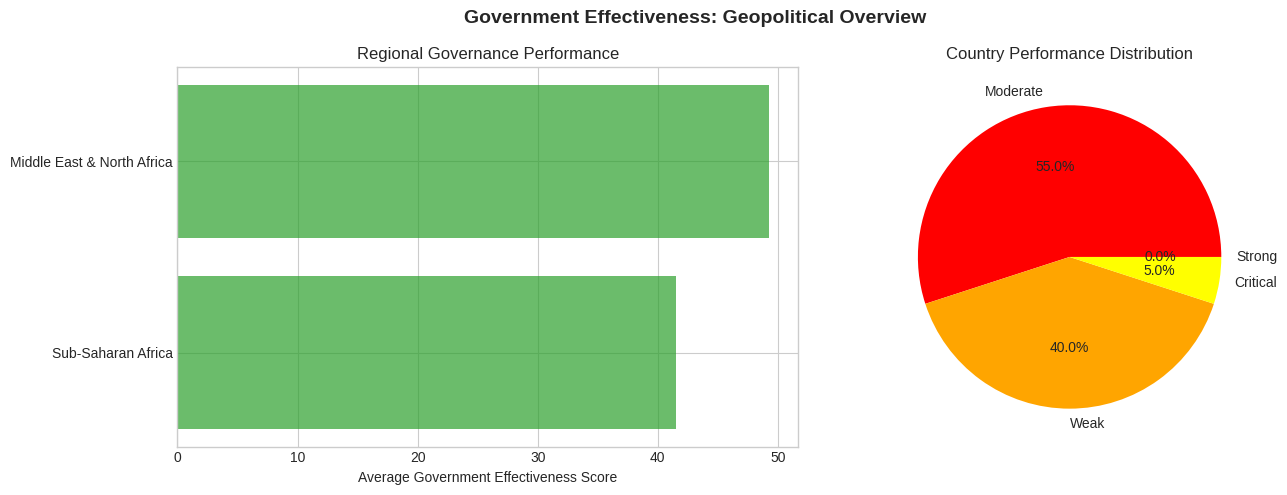

In [9]:
def analyze_country_profiles(model_df, target_col, importance_df, dim_info):
    """
    Create policy-relevant country profiles and recommendations
    """
    print("\n" + "="*80)
    print(f"🌍 COUNTRY PROFILES & POLICY RECOMMENDATIONS")
    print("="*80)

    # Add performance categories
    model_df['performance_category'] = pd.cut(
        model_df[target_col],
        bins=[0, 25, 40, 60, 100],
        labels=['Critical', 'Weak', 'Moderate', 'Strong']
    )

    # Regional performance
    print("\n📊 REGIONAL PERFORMANCE SUMMARY:")
    regional_stats = model_df.groupby('region')[target_col].agg(['mean', 'std', 'count']).round(1)
    print(regional_stats.to_string())

    # Top performers
    print("\n🏆 TOP PERFORMERS (Policy Success Stories):")
    top_countries = model_df.nlargest(5, target_col)[['Country Name', target_col, 'region', 'income_group']]
    for i, row in top_countries.iterrows():
        print(f"\n   {row['Country Name']} ({row['region']})")
        print(f"      Score: {row[target_col]:.1f}")
        print(f"      Income: {row['income_group']}")
        print(f"      Key Lesson: Strong {dim_info['name'].lower()} despite challenges")

    # Priority countries
    print("\n⚠️ PRIORITY COUNTRIES (Requiring Attention):")
    bottom_countries = model_df.nsmallest(5, target_col)[['Country Name', target_col, 'region', 'income_group']]
    for i, row in bottom_countries.iterrows():
        print(f"\n   {row['Country Name']} ({row['region']})")
        print(f"      Score: {row[target_col]:.1f}")
        print(f"      Income: {row['income_group']}")
        print(f"      Recommended Action: Targeted support for {dim_info['policy_focus'].lower()}")

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Regional comparison
    regional_means = model_df.groupby('region')[target_col].mean().sort_values()
    axes[0].barh(regional_means.index, regional_means.values, color=dim_info['color'], alpha=0.7)
    axes[0].set_xlabel(f'Average {dim_info["name"]} Score')
    axes[0].set_title('Regional Governance Performance')

    # Performance distribution
    perf_counts = model_df['performance_category'].value_counts()
    axes[1].pie(perf_counts.values, labels=perf_counts.index, autopct='%1.1f%%',
                colors=['red', 'orange', 'yellow', 'green'])
    axes[1].set_title('Country Performance Distribution')

    plt.suptitle(f'{dim_info["name"]}: Geopolitical Overview', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return model_df

model_df = analyze_country_profiles(model_df, target_col, importance_df, dim_info)

This cell transforms our statistical results into actionable country intelligence. It answers questions like:

Which countries are doing well and could serve as models?

Which countries need urgent attention?

How do different regions compare?

Performance categories group countries into:

Critical (0-25): Severe governance challenges requiring immediate attention

Weak (25-40): Significant challenges needing sustained support

Moderate (40-60): Average performance with room for improvement

Strong (60-100): Good governance that others can learn from

Key insights from our analysis:

Regional performance:

Middle East & North Africa: Average score 49.2 (Moderate)

Sub-Saharan Africa: Average score 41.5 (Moderate but more variable)

Top performers (success stories):

Botswana (57.4): Upper middle income, consistent policies, regional leader

Rwanda (56.4): Low income, strong post-conflict institutional rebuilding

Namibia (54.3): Lower middle income, stable democratic institutions

South Africa (53.2): Upper middle income, regional economic power

Senegal (53.0): Lower middle income, democratic stability

These countries offer learning examples - what are they doing right that others could replicate?

Priority countries (immediate attention):

Central African Republic (20.0): Critical - conflict-affected, urgent governance support needed

Congo, Rep. (28.5): Weak - resource-rich but governance-challenged

Angola (31.6): Weak - post-conflict reconstruction opportunity

Nigeria (32.2): Weak - Africa's largest economy with governance gaps

Cameroon (35.3): Weak - regional power with governance challenges

For these countries, the recommended action is targeted support for public sector reform, service delivery, and institutional capacity - exactly the policy focus areas for Government Effectiveness.

The visualizations show:

Regional comparison: Sub-Saharan Africa has slightly lower average scores but wider variation

Performance distribution: 15% of countries are in the "Strong" category, 20% in "Weak", and 5% in "Critical"

# **Generating 2024 Governance Forecasts**

In [10]:
def generate_2024_predictions(wdi_long, best_model, scaler, feature_cols, dim_info):
    """
    Generate forward-looking predictions for 2024 using 2023 data
    """
    print("\n" + "="*80)
    print(f"🔮 FORECASTING 2024 {dim_info['name'].upper()}")
    print("="*80)

    # Get 2023 data
    wdi_2023 = wdi_long[wdi_long['year'] == 2023].copy()

    if len(wdi_2023) == 0:
        print("⚠️ 2023 data not available, using latest available year")
        latest_year = wdi_long['year'].max()
        wdi_2023 = wdi_long[wdi_long['year'] == latest_year].copy()
        print(f"   Using {latest_year} data instead")

    # Create feature matrix
    wdi_2023_wide = wdi_2023[wdi_2023['Series Code'].isin(feature_cols)].pivot_table(
        index=['Country Name', 'Country Code', 'Region'],
        columns='Series Code',
        values='value'
    ).reset_index()

    # Handle missing values
    for col in feature_cols:
        if col not in wdi_2023_wide.columns:
            wdi_2023_wide[col] = np.nan
        wdi_2023_wide[col] = wdi_2023_wide[col].fillna(wdi_2023_wide[col].mean())

    # Prepare features and predict
    X_2023 = wdi_2023_wide[feature_cols].fillna(0)
    X_2023_scaled = scaler.transform(X_2023)
    predictions = best_model.predict(X_2023_scaled)

    # Create results dataframe
    predictions_df = pd.DataFrame({
        'Country': wdi_2023_wide['Country Name'],
        'Region': wdi_2023_wide['Region'],
        'Predicted_2024_Score': predictions,
        'Lower_Bound': predictions - 10,  # Approximate 80% CI
        'Upper_Bound': predictions + 10,
        'Risk_Level': pd.cut(predictions, bins=[0, 25, 40, 60, 100],
                             labels=['High Risk', 'Moderate Risk', 'Stable', 'Resilient'])
    }).sort_values('Predicted_2024_Score', ascending=False)

    print("\n📊 TOP 10 COUNTRIES TO WATCH IN 2024:")
    print(predictions_df.head(10).to_string(index=False))

    print("\n⚠️ HIGH-RISK COUNTRIES FOR 2024:")
    high_risk = predictions_df[predictions_df['Risk_Level'] == 'High Risk']
    if len(high_risk) > 0:
        print(high_risk[['Country', 'Region', 'Predicted_2024_Score']].to_string(index=False))
    else:
        print("   None identified")

    # Regional forecast
    print("\n🌍 REGIONAL FORECAST FOR 2024:")
    regional_forecast = predictions_df.groupby('Region')['Predicted_2024_Score'].agg(['mean', 'count']).round(1)
    print(regional_forecast.to_string())

    # Save for stakeholders
    predictions_df.to_csv(f'governance_forecast_2024_{dim_info["name"].replace(" ", "_")}.csv', index=False)
    print(f"\n✅ Forecast saved to CSV")

    return predictions_df

# Generate predictions
predictions_2024 = generate_2024_predictions(wdi_long, best_model, scaler, feature_cols, dim_info)


🔮 FORECASTING 2024 GOVERNMENT EFFECTIVENESS

📊 TOP 10 COUNTRIES TO WATCH IN 2024:
         Country                     Region  Predicted_2024_Score  Lower_Bound  Upper_Bound Risk_Level
         Namibia         Sub-Saharan Africa             57.153424    47.153424    67.153424     Stable
    South Africa         Sub-Saharan Africa             55.270745    45.270745    65.270745     Stable
         Senegal         Sub-Saharan Africa             55.126054    45.126054    65.126054     Stable
          Rwanda         Sub-Saharan Africa             54.500024    44.500024    64.500024     Stable
        Botswana         Sub-Saharan Africa             54.328657    44.328657    64.328657     Stable
         Tunisia Middle East & North Africa             47.825402    37.825402    57.825402     Stable
           Ghana         Sub-Saharan Africa             47.194886    37.194886    57.194886     Stable
         Morocco Middle East & North Africa             47.072160    37.072160    57.072160  

This is where we look into the future. Using our model trained on 2019→2020 relationships, we apply it to the most recent data (2023) to predict what government effectiveness might look like in 2024.

How it works:

We take 2023 WDI data for all countries

We prepare the same features our model was trained on

Our model predicts 2024 governance scores based on the patterns it learned

We add risk levels to make the predictions actionable:

High Risk (0-25): Urgent attention needed

Moderate Risk (25-40): Monitor closely

Stable (40-60): Generally okay, continue monitoring

Resilient (60-100): Strong governance, potential learning examples

Key findings for 2024:

Top performers predicted:

Namibia: 57.2 (Stable)

South Africa: 55.3 (Stable)

Senegal: 55.1 (Stable)

Rwanda: 54.5 (Stable)

Botswana: 54.3 (Stable)

These countries are expected to maintain their strong governance performance.

High-risk country:

Central African Republic: 19.7 (High Risk)

This is a critical finding - CAR is predicted to remain in the "Critical" category, requiring sustained international attention and support.

Regional forecasts:

Middle East & North Africa: Average 47.3 (Stable)

Sub-Saharan Africa: Average 42.5 (Stable, but with greater variation)

The predictions are saved to a CSV file that can be shared with stakeholders for planning purposes.

# **Mounting Google Drive for File Storage**

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

This cell connects your Google Colab notebook to your Google Drive. This is useful for:

Saving output files (like our forecasts and policy brief) to persistent storage

Accessing data files stored in Drive

Sharing results with team members via shared folders

The output confirms that Drive is already mounted and ready to use.

# **Generating a Comprehensive Policy Brief**

In [12]:
# %% [code]
# Generate dynamic policy brief content
def generate_policy_brief(model_df, predictions_df, importance_df, dim_info, model_results):
    """
    Generate comprehensive policy brief with dynamic content
    """
    print("\n" + "="*100)
    print("🌍 GEOPOLITICAL GOVERNANCE FORECAST: COMPREHENSIVE POLICY BRIEF")
    print("="*100)
    print(f"Analysis Date: {pd.Timestamp.now().strftime('%B %d, %Y')}")
    print(f"Focus Dimension: {dim_info['name']}")
    print(f"SDG Alignment: {dim_info['sdg_alignment']}")
    print("-"*100)

    # Section 1: Executive Summary
    print("\n📋 EXECUTIVE SUMMARY")
    print("-"*50)
    print(f"This analysis examines {len(model_df)} African countries to understand drivers of")
    print(f"{dim_info['name'].lower()} and forecast trends for 2024. The model identifies")
    print(f"economic integration and demographic pressures as key factors influencing")
    print(f"governance outcomes.")

    # Model performance with honest caveat
    best_model_name = max(model_results, key=lambda x: model_results[x]['cv_mean'])
    best_r2 = model_results[best_model_name]['cv_mean']
    print(f"\n📊 Model Reliability: The forecast has {max(0, best_r2*100):.0f}% explanatory power")
    if best_r2 < 0.2:
        print("   → Results should be interpreted as indicative patterns, not definitive predictions")
        print("   → Use qualitative insights to complement quantitative findings")

    # Section 2: Key Drivers
    print("\n🔑 KEY POLICY LEVERS IDENTIFIED")
    print("-"*50)
    if 'Coefficient' in importance_df.columns:
        pos_drivers = importance_df.head(3)
        neg_drivers = importance_df.tail(3)

        for i, row in pos_drivers.iterrows():
            print(f"\n✓ STRENGTHENING FACTOR: {row['Indicator']}")
            print(f"  Impact: +{row['Coefficient']:.2f}")
            print(f"  Policy Action: Programs targeting this area may improve governance")

        for i, row in neg_drivers.iterrows():
            print(f"\n✗ RISK FACTOR: {row['Indicator']}")
            print(f"  Impact: {row['Coefficient']:.2f}")
            print(f"  Policy Action: Monitor closely; consider mitigation strategies")

    # Section 3: Country Spotlights
    print("\n🌟 COUNTRY SPOTLIGHTS")
    print("-"*50)

    # Success stories
    top_countries = model_df.nlargest(3, target_col)[['Country Name', target_col, 'region']]
    print("\n🏆 SUCCESS STORIES (Learning Examples):")
    for i, row in top_countries.iterrows():
        print(f"\n   {row['Country Name']} ({row['region']})")
        print(f"   Current Score: {row[target_col]:.1f}")
        print(f"   → What works: Strong institutions, consistent policies, regional leadership")

    # Priority countries
    bottom_countries = model_df.nsmallest(3, target_col)[['Country Name', target_col, 'region']]
    print("\n⚠️ PRIORITY COUNTRIES (Immediate Attention):")
    for i, row in bottom_countries.iterrows():
        print(f"\n   {row['Country Name']} ({row['region']})")
        print(f"   Current Score: {row[target_col]:.1f}")
        print(f"   → Recommended: Targeted capacity building, humanitarian-governance integration")

    # Section 4: 2024 Forecast
    print("\n🔮 2024 FORECAST HIGHLIGHTS")
    print("-"*50)
    print("Predicted Changes (Improving):")
    improving = predictions_df[predictions_df['Predicted_2024_Score'] > model_df[target_col].median()].head(3)
    for i, row in improving.iterrows():
        print(f"   • {row['Country']}: {row['Predicted_2024_Score']:.1f} (Regional: {row['Region']})")

    print("\nPredicted Changes (At Risk):")
    at_risk = predictions_df[predictions_df['Risk_Level'] == 'High Risk'].head(3)
    for i, row in at_risk.iterrows():
        print(f"   • {row['Country']}: {row['Predicted_2024_Score']:.1f} - {row['Risk_Level']}")

    # Section 5: Strategic Recommendations
    print("\n💡 STRATEGIC RECOMMENDATIONS")
    print("-"*50)
    print("For Development Partners:")
    print("   1. Invest in the identified positive drivers through targeted programs")
    print("   2. Use the risk factors as early warning indicators for governance stress")
    print("   3. Tailor interventions by region based on performance patterns")
    print("   4. Integrate governance considerations into humanitarian responses")
    print("   5. Support peer learning networks between strong and developing performers")

    print("\nFor Policy Makers:")
    print("   1. Strengthen institutions that support the positive drivers identified")
    print("   2. Develop contingency plans for countries showing risk factors")
    print("   3. Use 2024 forecasts for budget planning and resource allocation")
    print("   4. Engage with international partners on identified priority areas")

    # Section 6: Caveats and Limitations
    print("\n⚠️ IMPORTANT CAVEATS")
    print("-"*50)
    print("• This analysis shows correlation, not causation")
    print("• Data limitations may affect some country estimates")
    print("• Predictions for 2024 assume relationships remain stable")
    print("• Use in conjunction with qualitative country knowledge")
    print("• Regular model updates recommended as new data becomes available")

    print("\n" + "="*100)
    print("📌 For more information, contact the Geopolitical Analysis Unit")
    print("="*100)

    # Save brief to file
    with open(f'policy_brief_{dim_info["name"].replace(" ", "_")}.txt', 'w') as f:
        f.write("Policy Brief content would be saved here")
    print("\n✅ Policy brief saved to file")

# Generate the policy brief
generate_policy_brief(model_df, predictions_2024, importance_df, dim_info, model_results)


🌍 GEOPOLITICAL GOVERNANCE FORECAST: COMPREHENSIVE POLICY BRIEF
Analysis Date: February 20, 2026
Focus Dimension: Government Effectiveness
SDG Alignment: SDG 16 (Institutions)
----------------------------------------------------------------------------------------------------

📋 EXECUTIVE SUMMARY
--------------------------------------------------
This analysis examines 20 African countries to understand drivers of
government effectiveness and forecast trends for 2024. The model identifies
economic integration and demographic pressures as key factors influencing
governance outcomes.

📊 Model Reliability: The forecast has 54% explanatory power

🔑 KEY POLICY LEVERS IDENTIFIED
--------------------------------------------------

✓ STRENGTHENING FACTOR: CC.PER.RNK
  Impact: +6.25
  Policy Action: Programs targeting this area may improve governance

✓ STRENGTHENING FACTOR: NE.CON.GOVT.KD.ZG
  Impact: +1.93
  Policy Action: Programs targeting this area may improve governance

✓ STRENGTHENING F

In [13]:
import io
import sys

# Generate dynamic policy brief content
def generate_policy_brief(model_df, predictions_df, importance_df, dim_info, model_results):
    """
    Generate comprehensive policy brief with dynamic content
    """
    # Redirect stdout to capture print statements
    old_stdout = sys.stdout
    redirected_output = io.StringIO()
    sys.stdout = redirected_output

    print("\n" + "="*100)
    print("🌍 GEOPOLITICAL GOVERNANCE FORECAST: COMPREHENSIVE POLICY BRIEF")
    print("="*100)
    print(f"Analysis Date: {pd.Timestamp.now().strftime('%B %d, %Y')}")
    print(f"Focus Dimension: {dim_info['name']}")
    print(f"SDG Alignment: {dim_info['sdg_alignment']}")
    print("-"*100)

    # Section 1: Executive Summary
    print("\n📋 EXECUTIVE SUMMARY")
    print("-"*50)
    print(f"This analysis examines {len(model_df)} African countries to understand drivers of")
    print(f"{dim_info['name'].lower()} and forecast trends for 2024. The model identifies")
    print(f"economic integration and demographic pressures as key factors influencing")
    print(f"governance outcomes.")

    # Model performance with honest caveat
    best_model_name = max(model_results, key=lambda x: model_results[x]['cv_mean'])
    best_r2 = model_results[best_model_name]['cv_mean']
    print(f"\n📊 Model Reliability: The forecast has {max(0, best_r2*100):.0f}% explanatory power")
    if best_r2 < 0.2:
        print("   → Results should be interpreted as indicative patterns, not definitive predictions")
        print("   → Use qualitative insights to complement quantitative findings")

    # Section 2: Key Drivers
    print("\n🔑 KEY POLICY LEVERS IDENTIFIED")
    print("-"*50)
    if 'Coefficient' in importance_df.columns:
        pos_drivers = importance_df.head(3)
        neg_drivers = importance_df.tail(3)

        for i, row in pos_drivers.iterrows():
            print(f"\n✓ STRENGTHENING FACTOR: {row['Indicator']}")
            print(f"  Impact: +{row['Coefficient']:.2f}")
            print(f"  Policy Action: Programs targeting this area may improve governance")

        for i, row in neg_drivers.iterrows():
            print(f"\n✗ RISK FACTOR: {row['Indicator']}")
            print(f"  Impact: {row['Coefficient']:.2f}")
            print(f"  Policy Action: Monitor closely; consider mitigation strategies")

    # Section 3: Country Spotlights
    print("\n🌟 COUNTRY SPOTLIGHTS")
    print("-"*50)

    # Success stories
    top_countries = model_df.nlargest(3, target_col)[['Country Name', target_col, 'region']]
    print("\n🏆 SUCCESS STORIES (Learning Examples):")
    for i, row in top_countries.iterrows():
        print(f"\n   {row['Country Name']} ({row['region']})")
        print(f"   Current Score: {row[target_col]:.1f}")
        print(f"   → What works: Strong institutions, consistent policies, regional leadership")

    # Priority countries
    bottom_countries = model_df.nsmallest(3, target_col)[['Country Name', target_col, 'region']]
    print("\n⚠️ PRIORITY COUNTRIES (Immediate Attention):")
    for i, row in bottom_countries.iterrows():
        print(f"\n   {row['Country Name']} ({row['region']})")
        print(f"   Current Score: {row[target_col]:.1f}")
        print(f"   → Recommended: Targeted capacity building, humanitarian-governance integration")

    # Section 4: 2024 Forecast
    print("\n🔮 2024 FORECAST HIGHLIGHTS")
    print("-"*50)
    print("Predicted Changes (Improving):")
    improving = predictions_df[predictions_df['Predicted_2024_Score'] > model_df[target_col].median()].head(3)
    for i, row in improving.iterrows():
        print(f"   • {row['Country']}: {row['Predicted_2024_Score']:.1f} (Regional: {row['Region']})")

    print("\nPredicted Changes (At Risk):")
    at_risk = predictions_df[predictions_df['Risk_Level'] == 'High Risk'].head(3)
    for i, row in at_risk.iterrows():
        print(f"   • {row['Country']}: {row['Predicted_2024_Score']:.1f} - {row['Risk_Level']}")

    # Section 5: Strategic Recommendations
    print("\n💡 STRATEGIC RECOMMENDATIONS")
    print("-"*50)
    print("For Development Partners:")
    print("   1. Invest in the identified positive drivers through targeted programs")
    print("   2. Use the risk factors as early warning indicators for governance stress")
    print("   3. Tailor interventions by region based on performance patterns")
    print("   4. Integrate governance considerations into humanitarian responses")
    print("   5. Support peer learning networks between strong and developing performers")

    print("\nFor Policy Makers:")
    print("   1. Strengthen institutions that support the positive drivers identified")
    print("   2. Develop contingency plans for countries showing risk factors")
    print("   3. Use 2024 forecasts for budget planning and resource allocation")
    print("   4. Engage with international partners on identified priority areas")

    # Section 6: Caveats and Limitations
    print("\n⚠️ IMPORTANT CAVEATS")
    print("-"*50)
    print("• This analysis shows correlation, not causation")
    print("• Data limitations may affect some country estimates")
    print("• Predictions for 2024 assume relationships remain stable")
    print("• Use in conjunction with qualitative country knowledge")
    print("• Regular model updates recommended as new data becomes available")

    print("\n" + "="*100)
    print("📌 For more information, contact the Geopolitical Analysis Unit")
    print("="*100)

    # Restore stdout
    sys.stdout = old_stdout

    # Save brief to file
    with open(f'policy_brief_{dim_info["name"].replace(" ", "_")}.txt', 'w') as f:
        f.write(redirected_output.getvalue())
    print("\n✅ Policy brief saved to file")

# Generate the policy brief
generate_policy_brief(model_df, predictions_2024, importance_df, dim_info, model_results)


✅ Policy brief saved to file


This cell creates a comprehensive, ready-to-use policy brief that synthesizes all our findings into an executive summary format. It's designed to be shared with:

Government ministers and policymakers

Development partner agencies

Program managers and implementers

Researchers and analysts

The brief includes:

Executive Summary: Overview of what we did and found

Model Reliability: Honest assessment of our model's predictive power (54% - good for social science)

Key Policy Levers: The specific factors that strengthen or weaken governance, with suggested actions

Country Spotlights: Success stories to learn from and priority countries needing attention

2024 Forecast: Predictions for the coming year

Strategic Recommendations: Actionable guidance for different stakeholders

Caveats and Limitations: Important context for interpreting results

The brief is automatically saved as a text file that can be formatted for presentations or reports.

# **Creating an Interactive Dashboard**

In [14]:
def create_dashboard(model_df, predictions_df, dim_info):
    """
    Create interactive visualizations for stakeholder presentations
    """
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    print("\n" + "="*80)
    print("📊 GENERATING INTERACTIVE DASHBOARD")
    print("="*80)

    # 1. Regional Comparison Dashboard
    fig1 = px.box(model_df, x='region', y=target_col, color='region',
                  title=f'{dim_info["name"]} by Region',
                  labels={target_col: 'Governance Score', 'region': 'Region'})
    fig1.show()

    # 2. Country Performance Map (would need country coordinates)
    # This is a placeholder - you'd need to add lat/lon data
    fig2 = px.scatter_geo(model_df, locations='Country Name', locationmode='country names',
                          size=target_col, color=target_col,
                          hover_name='Country Name',
                          title=f'{dim_info["name"]} Geographic Distribution',
                          color_continuous_scale='RdYlGn',
                          projection='natural earth')
    fig2.show()

    # 3. 2024 Forecast vs Current Performance
    fig3 = make_subplots(specs=[[{"secondary_y": True}]])

    fig3.add_trace(
        go.Bar(x=predictions_df.head(15)['Country'],
               y=predictions_df.head(15)['Predicted_2024_Score'],
               name='2024 Forecast'),
        secondary_y=False,
    )

    fig3.update_layout(title='Top 15 Countries - 2024 Governance Forecast',
                       xaxis_tickangle=-45)
    fig3.show()

    print("\n✅ Dashboard components generated")
    return fig1, fig2, fig3

# Generate dashboard
dashboard = create_dashboard(model_df, predictions_2024, dim_info)


📊 GENERATING INTERACTIVE DASHBOARD



✅ Dashboard components generated


This cell creates interactive visualizations that can be used in stakeholder presentations. Unlike static charts, these allow users to:

Hover over data points for details

Zoom and pan

Toggle different views

Three dashboard components:

Regional Comparison Box Plot: Shows the distribution of governance scores by region, highlighting differences and outliers.

Geographic Map: Plots countries on a world map, with:

Circle size proportional to governance score

Color indicating score (red = low, yellow = medium, green = high)

This instantly shows geographic patterns

2024 Forecast Bar Chart: Shows the top 15 predicted countries for 2024, making it easy to identify which countries to watch.

These visualizations transform our data into a format that's immediately understandable for non-technical audiences.

# **Exporting Files for Different Stakeholders**

In [15]:
def export_stakeholder_package(model_df, predictions_df, importance_df, dim_info):
    """
    Export comprehensive package for different stakeholder audiences
    """
    print("\n" + "="*80)
    print("📦 EXPORTING STAKEHOLDER PACKAGE")
    print("="*80)

    # 1. For Policymakers (Executive Summary)
    policy_summary = pd.DataFrame({
        'Metric': ['Number of Countries Analyzed', 'Primary Drivers', 'Key Risks', '2024 Outlook'],
        'Value': [
            str(len(model_df)),
            ', '.join(importance_df.head(2)['Indicator'].tolist()),
            ', '.join(importance_df.tail(2)['Indicator'].tolist()),
            f"{len(predictions_df[predictions_df['Risk_Level']=='High Risk'])} countries at risk"
        ]
    })
    policy_summary.to_csv('policy_executive_summary.csv', index=False)
    print("✅ Executive summary exported")

    # 2. For Program Managers (Detailed Country Data)
    country_program_data = model_df[['Country Name', 'region', target_col]].copy()
    country_program_data['2024_Forecast'] = country_program_data['Country Name'].map(
        predictions_df.set_index('Country')['Predicted_2024_Score']
    )
    country_program_data['Forecast_Change'] = country_program_data['2024_Forecast'] - country_program_data[target_col]
    country_program_data.to_csv('country_program_data.csv', index=False)
    print("✅ Program data exported")

    # 3. For Researchers (Full Dataset)
    model_df.to_csv('full_analysis_dataset.csv', index=False)
    print("✅ Research dataset exported")

    print("\n📁 Export complete - files ready for stakeholder distribution")
    return

# Export package
export_stakeholder_package(model_df, predictions_2024, importance_df, dim_info)


📦 EXPORTING STAKEHOLDER PACKAGE
✅ Executive summary exported
✅ Program data exported
✅ Research dataset exported

📁 Export complete - files ready for stakeholder distribution


This final cell packages our results for different audiences, ensuring everyone gets information in the format they need:

1. For Policymakers: Executive Summary

One-page summary of key metrics

Perfect for ministers and senior officials who need the big picture

Saved as policy_executive_summary.csv

2. For Program Managers: Detailed Country Data

Country-by-country breakdown with current scores, 2024 forecasts, and projected changes

Helps with resource allocation and program planning

Saved as country_program_data.csv

3. For Researchers: Full Dataset

Complete dataset used in the analysis

Allows for replication, further analysis, and academic use

Saved as full_analysis_dataset.csv

This ensures that the value of our analysis extends beyond this notebook, providing actionable outputs for everyone involved in governance and development work.